# Modeling Workflow Example - Greenplum Database

----

Greenplum Database features used

* External tables - http://gpdb.docs.pivotal.io/530/ref_guide/sql_commands/CREATE_EXTERNAL_TABLE.html
* Window functions - http://gpdb.docs.pivotal.io/510/ref_guide/function-summary.html#topic29
* Apache MADlib - http://madlib.apache.org/
* Procedural language extension to Python - https://gpdb.docs.pivotal.io/530/ref_guide/extensions/pl_python.html

----

### Example Description

**Use case:**

Using available credit card application data build a classification model to predict whether or not a new application will be approved.

**Data:** 

Credit Approval Data Set found at UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/Credit+Approval

"This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. 

This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values."


----

## Index

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
    
### Data Loading

* <a href="#external_table">External Table Definition</a>
* <a href="#download_data">Download Data</a>
* <a href="#view_sample">View Sample</a>


### Data Audit

* <a href="#summary_statistics">Summary Statistics</a>


### Data Exploration

* <a href="#de_categorical">Categorical Columns</a>
* <a href="#de_continuous">Continuous Columns</a>


### Feature Engineering

* <a href="#fe_continuous">Continuous Features</a>
* <a href="#fe_one_hot">One Hot Encode Categorical Features</a>
* <a href="#fe_combine">Combine Continuous & Categorical Features</a>
* <a href="#fe_cats_dep">Plot Categorical Features By Response</a>
* <a href="#fe_chi_sq">Chi-squared Testing</a>
* <a href="#fe_corr">Correlation Testing</a>
* <a href="#fe_scatter">Scatter Plots</a>


### Model Development

* <a href="#train_vali_split">Training & Validation Sample Split</a>


* **Random Forest (MADlib)**
    * <a href="#rf_train_model">Train model</a>
    * <a href="#rf_variable_importance">Variable Importance</a>
    * <a href="#rf_score_out_of_sample">Score Validation Data</a>
    * <a href="#rf_auc">Area Under ROC Curve</a>
    * <a href="#rf_roc">Receiver Operating Characteristic Graph (ROC Curve)</a>
    * <a href="#rf_confusion_matrix">Confusion Matrix</a>
    * <a href="#rf_model_storage">Model Storage</a>
    
    
* **XGBoost (PL/Python)**
    * <a href="#xg_load_plpython_udf">Load PL/Python UDF</a>
    * <a href="#xg_train_model">Train model</a>
    * <a href="#xg_score_out_of_sample">Score Validation Data</a>
    * <a href="#xg_auc">Area Under ROC Curve</a>
    * <a href="#xg_roc">Receiver Operating Characteristic Graph (ROC Curve)</a>
    * <a href="#xg_confusion_matrix">Confusion Matrix</a>

### Model Scoring


* <a href="#model_scoring_Example">Model Scoring Example</a>

----


----
## Setup

<a id="dependencies"></a>

In [2]:
# dependencies
import psycopg2               # Python-PostgreSQL Database Adapter - https://pypi.python.org/pypi/psycopg2
import pandas as pd           # Python Data Analysis Library - https://pandas.pydata.org/
import seaborn as sns         # Statistical data visualization - https://seaborn.pydata.org/
import math                   # Mathematical functions - https://docs.python.org/2/library/math.html
import textwrap as tw         # Text wrapping and filling - https://docs.python.org/2/library/textwrap.html
import ipywidgets as widgets  # Jupyter Widgets - https://ipywidgets.readthedocs.io/en/latest/
import IPython.display as ipd # http://ipython.org/documentation.html

<a id="package_options"></a>

In [3]:
# package options
# %matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (12, 8)
    
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


<a id="database_connection"></a>

In [4]:
# init to default values
database_host = 'gpdb'
database_databasename = 'gpadmin'
database_username = 'gpadmin'
database_password = 'pivotal'
database_port = '5432'

# interpret string as markdown
def printmd(string):
    ipd.display(ipd.Markdown(string))
    
# forms
message = "### Connection Details \n ------"
printmd(message)
    
printmd("**Host:**")
inputHost = widgets.Text()
ipd.display(inputHost)

printmd("**Port:**")
inputPort = widgets.Text()
ipd.display(inputPort)

printmd("**Database Name:**")
inputDatabaseName = widgets.Text()
ipd.display(inputDatabaseName)

printmd("**Username:**")
inputUsername = widgets.Text()
ipd.display(inputUsername)

printmd("**Password:**")
inputPassword = widgets.Text()
ipd.display(inputPassword)

printmd("*Leave blank for default values*")


def db_connect():
    global conn, cur
    try:
        connString = "host='{}' dbname='{}' user='{}' password='{}' port={}".format(database_host,database_databasename,database_username,database_password,database_port)
        # print connString
        conn = psycopg2.connect(connString)
        cur = conn.cursor()
        conn.autocommit = True
        message = "<span style='color:green'>**Connection successful!**</span>"
        printmd(message)
    except:
        message = "<span style='color:red'>**ERROR: Unable to connect to the database**</span>"
        printmd(message)
    
def on_button_click(b):
    
    global database_host, database_databasename, database_username, database_password, database_port
    
    ipd.clear_output()
    
    message = "### Connection Details \n ------"
    printmd(message)
    
    if inputHost.value == "":
        message = "**Host:** {} (default)".format(database_host)
        printmd(message)
    else:
        database_host = inputHost.value
        message = "**Host:** {}".format(database_host)
        printmd(message)

    if inputPort.value == "":
        message = "**Port:** {} (default)".format(database_port)
        printmd(message)
    else:
        database_port = inputPort.value
        message = "**Port:** {}".format(database_port)
        printmd(message)
        
    if inputDatabaseName.value == "":
        message = "**Database name:** {} (default)".format(database_databasename)
        printmd(message)
    else:
        database_databasename = inputDatabaseName.value
        message = "**Database name:** {}".format(database_databasename)
        printmd(message)
        
    if inputUsername.value == "":
        message = "**Username:** {} (default)".format(database_username)
        printmd(message)
    else:
        database_username = inputUsername.value
        message = "**Username:** {}".format(database_username)
        printmd(message)
        
    if inputPassword.value == "":
        message = "**Password:** {} (default)".format(database_password)
        printmd(message)
    else:
        database_password = inputPassword.value
        message = "**Password:** ###########"
        printmd(message)
    
    printmd("------")
    db_connect()
        
button = widgets.Button(description="Connect")
ipd.display(button)
button.on_click(on_button_click)

### Connection Details 
 ------

**Host:** gpdb (default)

**Port:** 5432 (default)

**Database name:** gpadmin (default)

**Username:** gpadmin (default)

**Password:** pivotal (default)

------

<span style='color:green'>**Connection successful!**</span>

----
## Data Loading

<a id="external_table"></a>

In [5]:
# create external web table
ddl = """
    DROP EXTERNAL TABLE IF EXISTS public.credit_application_external;
    CREATE EXTERNAL WEB TABLE public.credit_application_external (
        a1 varchar(1)
       ,a2 float
       ,a3 float
       ,a4 varchar(1)
       ,a5 varchar(2)
       ,a6 varchar(2)
       ,a7 varchar(2)
       ,a8 float
       ,a9 boolean
       ,a10 boolean
       ,a11 float
       ,a12 boolean
       ,a13 varchar(1)
       ,a14 float
       ,a15 float
       ,a16 varchar(1)
    ) LOCATION ('http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data')
    FORMAT 'CSV'
    (NULL AS '?');
"""
cur.execute(ddl)

<a id="download_data"></a>

In [6]:
# impute mean or most freq occuring value for null 
query = """
    DROP TABLE IF EXISTS public.credit_application_data;
    CREATE TABLE public.credit_application_data AS
    SELECT row_number() OVER() AS _id
          ,coalesce(a1,'b') AS a1
          ,coalesce(a2, avg(a2) OVER()) AS a2
          ,coalesce(a3, avg(a3) OVER()) AS a3
          ,coalesce(a4, 'u') AS a4
          ,coalesce(a5, 'g') AS a5
          ,coalesce(a6, 'c') AS a6
          ,coalesce(a7, 'v') AS a7
          ,coalesce(a8, avg(a8) OVER()) AS a8
          ,coalesce(a9, True) AS a9
          ,coalesce(a10, False) AS a10
          ,coalesce(a11, 0) AS a11
          ,coalesce(a12, False) AS a12
          ,coalesce(a13, 'g') AS a13
          ,coalesce(a14, avg(a14) OVER()) AS a14
          ,coalesce(a15, avg(a15) OVER()) AS a15
          ,CASE WHEN a16 = '+' THEN 1 ELSE 0 END AS a16
    FROM public.credit_application_external
    DISTRIBUTED RANDOMLY;
"""
cur.execute(query)

<a id="view_sample"></a>

In [7]:
# helper function
def query_gpdb(query): 

    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

In [8]:
# view sample
query = """
    SELECT *
    FROM public.credit_application_data
    LIMIT 5
"""
query_gpdb(query)

,_id,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16
0,2,a,58.67,4.460,u,g,q,h,3.040,True,True,6.0,False,g,43.0,560.0,1
1,4,b,27.83,1.540,u,g,w,v,3.750,True,True,5.0,True,g,100.0,3.0,1
2,6,b,32.08,4.000,u,g,m,v,2.500,True,False,0.0,True,g,360.0,0.0,1
3,8,a,22.92,11.585,u,g,cc,v,0.040,True,False,0.0,False,g,80.0,1349.0,1
4,10,b,42.50,4.915,y,p,w,v,3.165,True,False,0.0,True,g,52.0,1442.0,1


----
## Data Audit

<a id="summary_statistics"></a>
Summary Statistics

https://madlib.apache.org/docs/latest/group__grp__summary.html

In [9]:
# drop existing table & run madlib summary stats function
query = """
    DROP TABLE IF EXISTS public.credit_application_summary;
    SELECT madlib.summary('public.credit_application_data','public.credit_application_summary');
"""
cur.execute(query)

# grab results from gpdb
query = """
    SELECT * FROM public.credit_application_summary;
"""
data_summary = query_gpdb(query)

In [10]:
data_summary

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,_id,1,int8,690,690,0,NaN,0.0,NaN,345.500000,3.973250e+04,1.00,690.00,173.250,345.500,517.7500,"[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,None,None,a1,2,varchar,690,2,0,0.0,0.0,0.0,NaN,NaN,1.00,1.00,NaN,NaN,NaN,"[b, b, a, a]","[480, 480, 210, 210]"
2,None,None,a2,3,float8,690,350,0,NaN,0.0,NaN,31.568171,1.405001e+02,13.75,80.25,22.670,28.625,37.7075,"[31.5681710914455, 31.5681710914455, 22.67, 20.42, 23.58, 18.83, 25, 24.5, 20.67, 19.17]","[12, 12, 9, 7, 6, 6, 6, 6, 6, 6]"
3,None,None,a3,4,float8,690,215,0,NaN,0.0,NaN,4.758725,2.478211e+01,0.00,28.00,1.000,2.750,7.2075,"[1.5, 1.5, 2.5, 0, 3, 3, 0, 2.5, 1.25, 0.75]","[21, 21, 19, 19, 19, 19, 19, 19, 16, 16]"
4,None,None,a4,5,varchar,690,3,0,0.0,0.0,0.0,NaN,NaN,1.00,1.00,NaN,NaN,NaN,"[u, u, y, y, l]","[525, 525, 163, 163, 2]"
5,None,None,a5,6,varchar,690,3,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[g, g, p, p, gg]","[525, 525, 163, 163, 2]"
6,None,None,a6,7,varchar,690,14,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[c, c, q, q, w, w, i, i, aa, aa]","[146, 146, 78, 78, 64, 64, 59, 59, 54, 54]"
7,None,None,a7,8,varchar,690,9,0,0.0,0.0,0.0,NaN,NaN,1.00,2.00,NaN,NaN,NaN,"[v, v, h, h, bb, bb, ff, ff, z, j]","[408, 408, 138, 138, 59, 59, 57, 57, 8, 8]"
8,None,None,a8,9,float8,690,132,0,NaN,0.0,NaN,2.223406,1.119915e+01,0.00,28.50,0.165,1.000,2.6250,"[0, 0, 0.25, 0.25, 0.04, 0.04, 1, 1, 0.125, 0.125]","[70, 70, 35, 35, 33, 33, 31, 31, 30, 30]"
9,None,None,a9,10,bool,690,2,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[t, t, f, f]","[361, 361, 329, 329]"


----
## Data Exploration

<a id="de_categorical"></a>
#### Categorical Columns

-----
 **Select Column:**

A Jupyter Widget

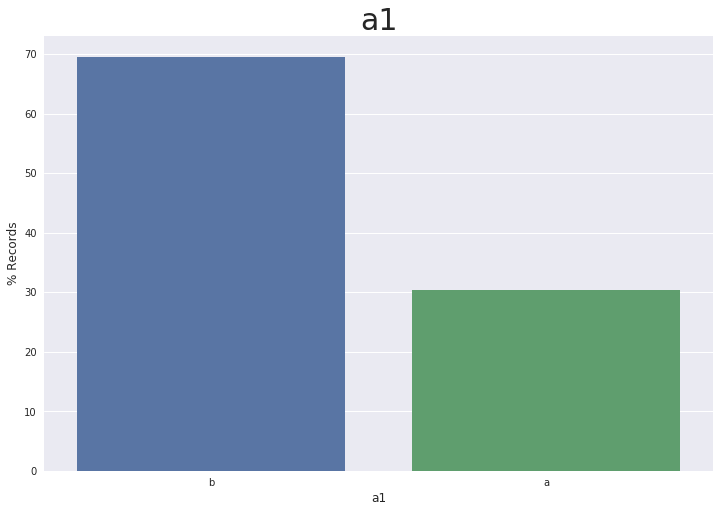

In [11]:
catColumns = ['a1','a4','a5','a6','a7','a9','a10','a12','a13','a16']

def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=12)
    plt.set_ylabel(yLabel,fontsize=12)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')


def get_cat_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,count(*) AS record_count
            FROM public.credit_application_data
            GROUP BY 1
        ) foo
        ORDER BY perc_records DESC
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catDropdown)
        df = get_cat_data_frame(res['new'])
        bar_plot(df,res['new'],"col",res['new'],"perc_records","% Records", None, 0)
    
catDropdown = widgets.Dropdown(
    options=catColumns,
    value=catColumns[0],
    description='Column:',
    disabled=False,
)

catDropdown.observe(on_cat_selection)
printmd("-----\n **Select Column:**")
ipd.display(catDropdown)
df = get_cat_data_frame(catColumns[0])
bar_plot(df,catColumns[0],"col",catColumns[0],"perc_records","% Records", None, 0)

* Low % of values in any one class can skew model results and/or create unstable model. In practice we may consider merging and/or excluding some groups. (e.g. a4: [i], a5: [gg], a7: [z,j,dd,n,o), a13: [s,p])

<a id="de_continuous"></a>
#### Continuous Columns

-----


A Jupyter Widget

-----


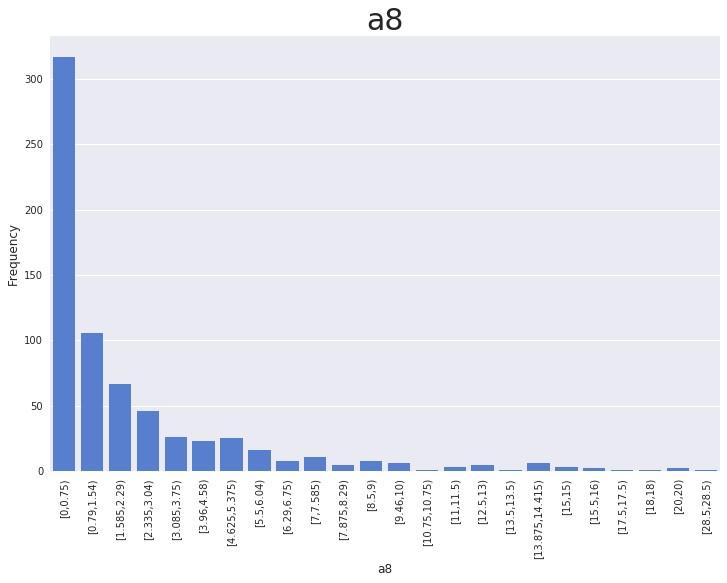

In [12]:
contColumns = ['a2','a3','a8','a11','a14','a15']
sliderValue = 20
colName = contColumns[0]

def get_cont_data_frame(col, buckets):
    query = """
        WITH aggs AS (
            SELECT min({c}) AS min,
                   max({c}) AS max
              FROM public.credit_application_data
        )
        SELECT width_bucket({c}, min, max, {b}-1) AS bucket,
               ('[' || min({c}) || ',' || max({c}) || ')')::text as range,
               count(*) as freq
        FROM public.credit_application_data, aggs
        GROUP BY bucket
        ORDER BY bucket
    """.format(c=col, b=buckets)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def graph_reset():
    ipd.clear_output()
    printmd("-----\n")
    ipd.display(widgets.HBox((contDropdown,bucketsSlider)))
    printmd("-----\n")
    df = get_cont_data_frame(colName,sliderValue)
    bar_plot(df,colName,"range",colName,"freq","Frequency", "#4378E2")    
    
def on_cont_selection(res):
    global colName
    if res['type'] == 'change' and res['name'] == 'value':
        colName = res['new']
        graph_reset()
        
def on_slider_selection(res):
    global sliderValue
    if res['new'] == {} and res['old']:
        sliderValue = res['old']['value']
        graph_reset()
    
# Look at log transforms
#colsAddLogs = contColumns + ["log({} + 1)".format(c) for c in contColumns]
colsAddLogs = contColumns

contDropdown = widgets.Dropdown(
    options=colsAddLogs,
    value=colsAddLogs[0],
    description='Column:',
    disabled=False,
)

bucketsSlider = widgets.IntSlider(
    value=sliderValue,
    min=5,
    max=50,
    step=1,
    description='# Buckets:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

contDropdown.observe(on_cont_selection)
bucketsSlider.observe(on_slider_selection)

graph_reset()



* a15 large number of outliers - consider correcting
* Consider variable transformation if test non-tree based algorithm
* Histogram values are being calculated in the database - minimal data movement back to client

----
## Feature Engineering

<a id="fe_continuous"></a>
#### Continuous Features

In [13]:
# continuos features (seperated out incase feature transformations are required)
query = """
    DROP TABLE IF EXISTS public.model_inputs_cont;
    CREATE TABLE public.model_inputs_cont AS
    SELECT _id
          ,a16 AS approval
          ,a2
          ,a3
          ,a8
          ,a11
          ,a14
          ,a15
    FROM public.credit_application_data
    DISTRIBUTED BY (_id);
    SELECT * FROM public.model_inputs_cont LIMIT 0;
"""
cur.execute(query)

contFeatureNames = [desc[0] for desc in cur.description]
contFeatureNames.remove('_id')
contFeatureNames.remove('approval')

query = """
    SELECT *
    FROM public.model_inputs_cont
"""
df = query_gpdb(query)

print len(df)

df.head()

690


,_id,approval,a2,a3,a8,a11,a14,a15
0,201,1,24.08,0.500,1.250,1.0,0.000000,678.0
1,203,1,24.83,2.750,2.250,6.0,184.014771,600.0
2,205,1,36.33,2.125,0.085,1.0,50.000000,1187.0
3,207,1,71.58,0.000,0.000,0.0,184.014771,0.0
4,209,1,35.17,2.500,4.500,7.0,150.000000,1270.0


<a id="fe_one_hot"></a>
#### One Hot Encode Categorical Features

https://madlib.apache.org/docs/latest/group__grp__encode__categorical.html

In [14]:
# encode categorical features
query = """
    DROP TABLE IF EXISTS public.model_inputs_cat;
    SELECT madlib.encode_categorical_variables (
        'public.credit_application_data',
        'public.model_inputs_cat',
        'a1,a4,a5,a6,a7,a9,a10,a12,a13',
        NULL,
        '_id',
        NULL,
        'a1=b, a4=y, a5=p, a6=x, a7=z, a9=False, a10=False, a12=False, a13=s'
    );
"""
cur.execute(query)

query = """
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a9_True" TO a9_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a10_True" TO a10_true;
    ALTER TABLE public.model_inputs_cat RENAME COLUMN "a12_True" TO a12_true;
"""
cur.execute(query)

query = """
    SELECT *
    FROM public.model_inputs_cat
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

colnames.remove('_id')
catFeatureNames = colnames
featureNames = contFeatureNames + catFeatureNames
print featureNames
df.head()

['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']


,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p
0,201,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0
1,203,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0
2,205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0
3,207,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,209,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0


<a id="fe_combine"></a>
#### Combine Continuous & Categorical Features

In [15]:
# combine feature tables
query = """
    DROP TABLE IF EXISTS public.model_inputs;
    CREATE TABLE public.model_inputs AS
    SELECT *
    FROM public.model_inputs_cat
    JOIN public.model_inputs_cont
    USING (_id);
"""
cur.execute(query)

<a id="fe_cats_dep"></a>
#### Plot Categorical Features By Response

-----
 **Select Column:**

A Jupyter Widget

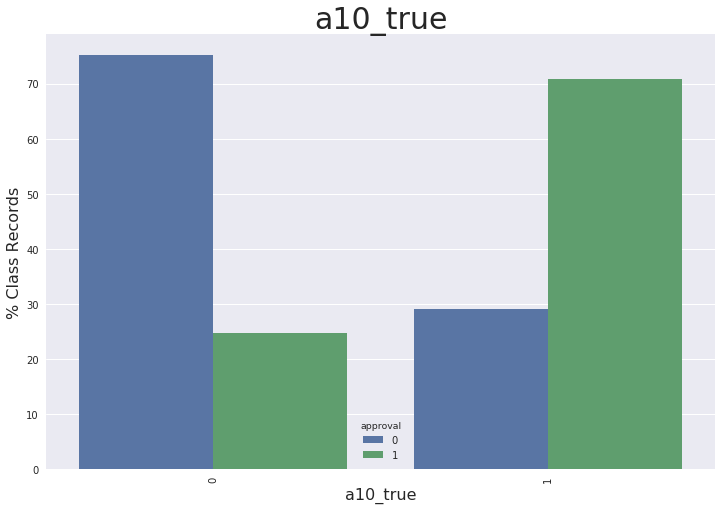

In [16]:
def bar_plot_groupby(data, title,x,xLabel,y,yLabel,groupby,color=None,axisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color, hue=groupby)
    else:
        plt = sns.barplot(x=x, y=y, data=data, hue=groupby)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(axisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

def get_cat_gb_data_frame(col):
    query = """
        SELECT *
              ,round((record_count * 100.0) / sum(record_count) OVER(PARTITION BY col),2) AS perc_records
        FROM (
            SELECT {} AS col
                  ,approval
                  ,count(*) AS record_count
            FROM public.model_inputs
            GROUP BY 1,2
        ) foo
        ORDER BY 1,2
    """.format(col)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)
    
def on_cat_gb_selection(res):
    if res['type'] == 'change' and res['name'] == 'value':
        ipd.clear_output()
        printmd("-----\n **Select Column:**")
        ipd.display(catGPDropdown)
        df = get_cat_gb_data_frame(res['new'])
        bar_plot_groupby(df,res['new'],"col",res['new'],"perc_records","% Class Records", "approval")
    
catGPDropdown = widgets.Dropdown(
    options=catFeatureNames,
    value=catFeatureNames[0],
    description='Column:',
    disabled=False,
)

catGPDropdown.observe(on_cat_gb_selection)
printmd("-----\n **Select Column:**")
ipd.display(catGPDropdown)
df = get_cat_gb_data_frame(catFeatureNames[0])
bar_plot_groupby(df,catFeatureNames[0],"col",catFeatureNames[0],"perc_records","% Class Records","approval")

* a9_true appears to be a strong variable due to seperate between classes

<a id="fe_chi_sq"></a>
#### Chi-squared testing

https://en.wikipedia.org/wiki/Chi-squared_test

https://madlib.apache.org/docs/latest/group__grp__stats__tests.html

,feature_name,response,statistic,p_value,df,phi,contingency_coef
0,a7_o,approval,0.024633,8.752845e-01,1,0.078475,0.078234
0,a6_c,approval,0.038090,8.452629e-01,1,0.097583,0.097122
0,a7_n,approval,0.049410,8.240931e-01,1,0.111142,0.110462
0,a6_m,approval,0.092817,7.606255e-01,1,0.152330,0.150593
0,a7_bb,approval,0.117396,7.318764e-01,1,0.171315,0.168855
0,a7_j,approval,0.160255,6.889216e-01,1,0.200159,0.196266
0,a7_dd,approval,0.305203,5.806390e-01,1,0.276226,0.266255
0,a1_a,approval,0.577660,4.472309e-01,1,0.380020,0.355234
0,a6_r,approval,0.599873,4.386265e-01,1,0.387257,0.361124
0,a12_true,approval,0.690089,4.061341e-01,1,0.415358,0.383585


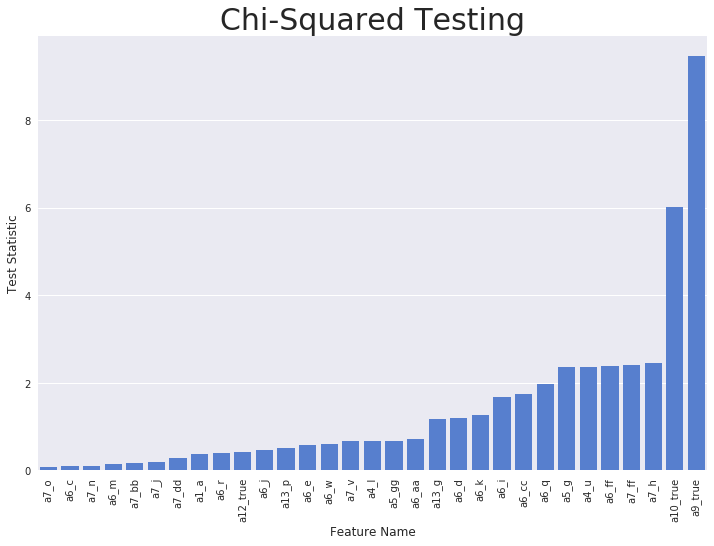

In [17]:
def chi2_gof_test(feature_name, response):
    query = """
        WITH freq AS (
            SELECT {feature_name}
                  ,{response}
                  ,count(*) AS observed
            FROM public.model_inputs
            GROUP BY 1,2
        )
        SELECT '{feature_name}' AS feature_name
              ,'{response}' AS response
              ,(madlib.chi2_gof_test(observed, expected, deg_freedom)).*
        FROM (
            SELECT observed
                  ,sum(observed) OVER (PARTITION BY {feature_name})::DOUBLE PRECISION
                       * sum(observed) OVER (PARTITION BY {response}) AS expected
            FROM freq
        ) l, (
            SELECT (count(distinct {feature_name}) - 1) * (count(distinct {response}) - 1) AS deg_freedom
            FROM freq
        ) r;
    """.format(feature_name=feature_name, response=response)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(cur.fetchall(), columns=colnames)

def chi2_gof_test_multi(feature_list, response):
    res = chi2_gof_test(feature_list[0], response)
    for i in range(1,len(feature_list)):
        res = res.append(chi2_gof_test(feature_list[i], response))
        
    return res

chi2_results = chi2_gof_test_multi(catFeatureNames, 'approval')
chi2_results.sort_values('phi', inplace=True)
ipd.display(chi2_results)
bar_plot(chi2_results, "Chi-Squared Testing","feature_name","Feature Name","phi","Test Statistic", "#4378E2")

<a id="fe_corr"></a>
#### Correlation Testing

https://madlib.apache.org/docs/latest/group__grp__correlation.html

In [18]:
# calc correlations
query = """
    DROP TABLE IF EXISTS public.feature_correlations, public.feature_correlations_summary;
    SELECT madlib.correlation( 
        'public.model_inputs',
        'public.feature_correlations',
        '{}'
    );
    SELECT * 
    FROM public.feature_correlations
    ORDER BY column_position;
""".format(",".join(contFeatureNames))
corr = query_gpdb(query)

corr.drop('column_position', 'columns', inplace=True)
corr.set_index('variable', True, False, True)
corr

,a2,a3,a8,a11,a14,a15
variable,,,,,,
a2,1.000000,NaN,NaN,NaN,NaN,NaN
a3,0.201316,1.000000,NaN,NaN,NaN,NaN
a8,0.392787,0.298902,1.000000,NaN,NaN,NaN
a11,0.185575,0.271207,0.322330,1.000000,NaN,NaN
a14,-0.077161,-0.222346,-0.076389,-0.119809,1.000000,NaN
a15,0.018539,0.123121,0.051345,0.063692,0.065609,1.0


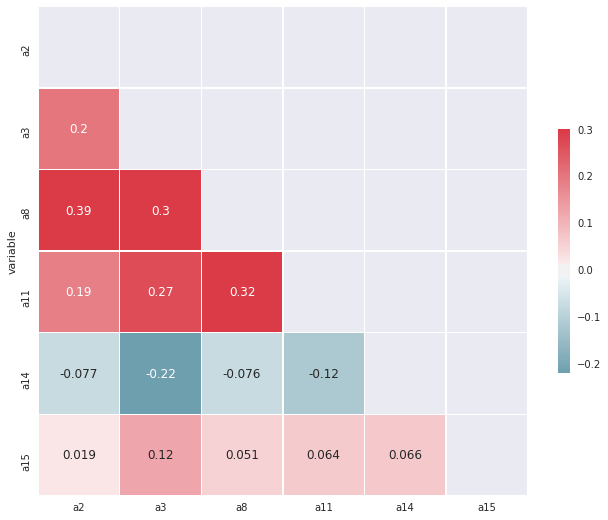

In [19]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<a id="fe_scatter"></a>
#### Scatter Plots

In [20]:
def sample_scatter(title, x, xLabel, y, yLabel, sampleSize):
    
    pylab.rcParams['figure.figsize'] = (8, 8)

    # Grab sample
    query = """
        SELECT count(*) AS n
        FROM public.model_inputs;
    """.format(",".join(contFeatureNames))
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    n = pd.DataFrame(cur.fetchall(), columns=colnames)['n'][0]
    limit = math.floor(n * sampleSize)
    
    query = """
        SELECT {} AS col1
              ,{} AS col2
        FROM public.model_inputs
        LIMIT {};
    """.format(x, y, limit)
    cur.execute(query)

    colnames = [desc[0] for desc in cur.description]
    sample = pd.DataFrame(cur.fetchall(), columns=colnames)    
    
    # Generate scatterplot
    if x == y:
        sample
    plt = sns.regplot(x="col1", y="col2", data=sample)
    
    # titles
    plt.set_title("\n".join(tw.wrap(title,50)),fontsize=16)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)

    # add 1000s commas
    plt.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
    plt.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

-----
 **Select Features:**

A Jupyter Widget

A Jupyter Widget

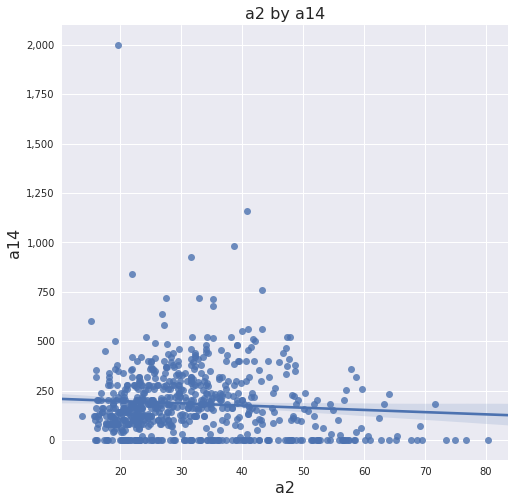

In [21]:
x = contFeatureNames[0]
y = contFeatureNames[1]

def reset():
    ipd.clear_output()
    printmd("-----\n **Select Features:**")
    ipd.display(scatterDropdown1, scatterDropdown2)

    sample_scatter("{} by {}".format(x, y), x, x, y, y, 1)   
    
def os1(res):
    global x
    if res['type'] == 'change' and res['name'] == 'value':
        contFeatureNames.append(x)
        x = res['new']
        contFeatureNames.remove(x)
        reset()

def os2(res):
    global y
    if res['type'] == 'change' and res['name'] == 'value':
        y = res['new']
        reset()
                   
scatterDropdown1 = widgets.Dropdown(
    options=contFeatureNames,
    value=x,
    description='x:',
    disabled=False,
)

scatterDropdown2 = widgets.Dropdown(
    options=contFeatureNames,
    value=y,
    description='y:',
    disabled=False,
)

scatterDropdown1.observe(os1)
scatterDropdown2.observe(os2)

reset()


----
## Model Training

<a id="train_vali_split"></a>
#### Training & Validation Sample Split

https://madlib.apache.org/docs/latest/group__grp__train__test__split.html

In [22]:
# split training and validation set
# we are careful not to include the same customer in both sets
query = """
    DROP TABLE IF EXISTS public.model
                        ,public.model_train
                        ,public.model_test;
                        
    SELECT madlib.train_test_split(
        'public.model_inputs',
        'public.model',
        0.7,
        NULL,
        NULL,
        '*',
        FALSE,
        TRUE
    )
"""
cur.execute(query)

In [23]:
query = """
    SELECT *
    FROM public.model_train
    LIMIT 5
"""
df = query_gpdb(query)
df

,_id,a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,approval,a2,a3,a8,a11,a14,a15
0,2,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,58.67,4.460,3.040,6.0,43.0,560.0
1,7,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,33.17,1.040,6.500,0.0,164.0,31285.0
2,11,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,22.08,0.830,2.165,0.0,128.0,0.0
3,18,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,23.25,5.875,3.170,10.0,120.0,245.0
4,22,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,23.25,1.000,0.835,0.0,300.0,0.0


### Random Forest (MADlib)

<a id="rf_train_model"></a>
#### Train model

https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [24]:
# train random forest model

query = """
DROP TABLE IF EXISTS public.rf_model_output, public.rf_model_output_summary, public.rf_model_output_group;
SELECT madlib.forest_train(
            'public.model_train',
            'public.rf_model_output',
            '_id',
            'approval',
            '{}',
            null,
            null,
            10::integer,
            5::integer,
            true::boolean,
            5::integer,
            10::integer,
            3::integer,
            1::integer,
            10::integer
        )
""".format(','.join(featureNames))
cur.execute(query)

In [25]:
# view model summary
query = """
    SELECT *
    FROM public.rf_model_output_summary
"""

df = query_gpdb(query)
df

,method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
0,forest_train,True,public.model_train,public.rf_model_output,_id,approval,"a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p,a2,a3,a8,a11,a14,a15","a1_a,a4_l,a4_u,a5_g,a5_gg,a6_aa,a6_c,a6_cc,a6_d,a6_e,a6_ff,a6_i,a6_j,a6_k,a6_m,a6_q,a6_r,a6_w,a7_bb,a7_dd,a7_ff,a7_h,a7_j,a7_n,a7_o,a7_v,a9_true,a10_true,a12_true,a13_g,a13_p","a2,a3,a8,a11,a14,a15",None,10,5,10,3,1,10,False,True,5,1,0,483,0,"""0"",""1""",integer,"integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, integer, double precision, double precision, double precision, double precision, double precision, double precision",None


<a id="rf_variable_importance"></a>
#### Variable Importance

,type,feature_name,feature_importance
0,cat,a9_true,-0.012862
1,con,a11,-0.087572
2,cat,a10_true,-0.092650
3,con,a8,-0.095976
4,cat,a13_g,-0.103430
5,cat,a7_h,-0.106695
6,con,a3,-0.106772
7,con,a14,-0.106825
8,cat,a7_v,-0.107078
9,cat,a7_ff,-0.107851


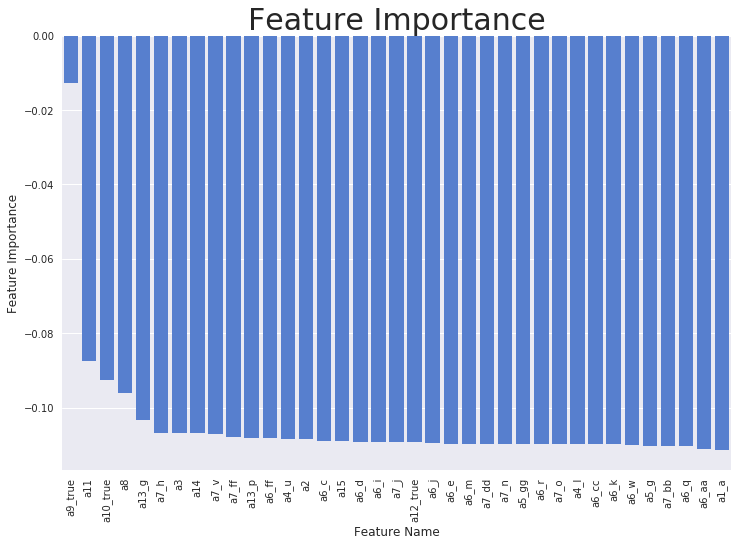

In [26]:
# feature importance
query = """
    SELECT 'cat' AS type
          ,unnest(string_to_array(cat_features,',')) AS feature_name
          ,unnest(cat_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    UNION
    SELECT 'con' AS type
          ,unnest(string_to_array(con_features,',')) AS feature_name
          ,unnest(con_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    ORDER BY 3 DESC
"""

df = query_gpdb(query)
ipd.display(df.head(10))
bar_plot(df,"Feature Importance","feature_name",'Feature Name',"feature_importance","Feature Importance", "#4378E2")


*Note - Variable importance is computed in MADlib RF as the difference in prediction
accuracy between original data and permuted data from out-of-bag
samples (OOB). Permuted data is defined as each variable resampled from
its own distribution. This value can end up being negative if the number
of levels for a variable is small and is unbalanced, as the
redistribution doesn't change the data much.*

<a id="rf_score_out_of_sample"></a>
#### Score Validation Data

https://madlib.apache.org/docs/latest/group__grp__random__forest.html

In [27]:
# Score out-of-sample
query = """
    DROP TABLE IF EXISTS public.model_test_scored;
    SELECT madlib.forest_predict('public.rf_model_output',
                                 'public.model_test',
                                 'public.model_test_scored',
                                 'prob');
                
    DROP TABLE IF EXISTS public.model_test_scored_tmp;
    CREATE TABLE public.model_test_scored_tmp AS
    SELECT *
    FROM public.model_test_scored
    JOIN public.model_test
    USING (_id);
    DROP TABLE public.model_test_scored;
    ALTER TABLE public.model_test_scored_tmp RENAME TO model_test_scored;
    SELECT * FROM public.model_test_scored LIMIT 0;
    
"""
cur.execute(query)

<a id="rf_auc"></a>
#### Area Under ROC Curve

In [28]:
# auc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_auc;
    SELECT madlib.area_under_roc(
        'public.model_test_scored'
       ,'public.model_test_scored_auc'
       ,'estimated_prob_1'
       ,'approval'
    )
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_test_scored_auc;
"""
auc = query_gpdb(query)['area_under_roc'][0]

message = """-----\n **AUC =** {:0.5f}""".format(auc)
printmd(message)

-----
 **AUC =** 0.89269

<a id="rf_roc"></a>
#### Receiver Operating Characteristic Graph (ROC Curve)

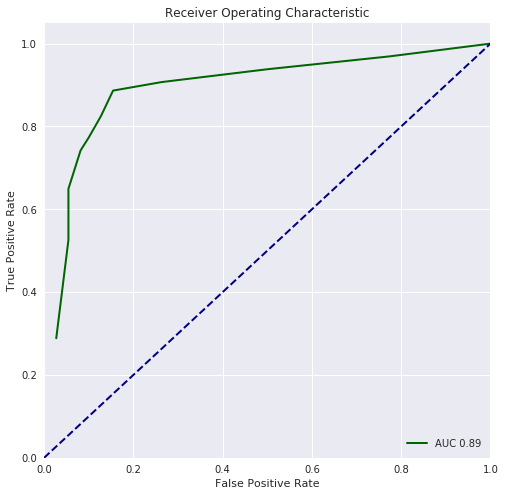

In [29]:
# roc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_roc;
    SELECT madlib.binary_classifier( 
        'public.model_test_scored'
       ,'public.model_test_scored_roc'
       ,'estimated_prob_1'
       ,'approval'
    );
"""
cur.execute(query)

query = """
    SELECT threshold
          ,fpr
          ,tpr
    FROM public.model_test_scored_roc
    ORDER BY 1
"""
df = query_gpdb(query)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<a id="rf_confusion_matrix"></a>
#### Confusion Matrix

In [30]:
# confusion matrix (inclusive)
cutoff = 0.5

query = """
        SELECT approval AS obs
              ,CASE WHEN estimated_prob_1 >= {} THEN 1 ELSE 0 END AS pred
              ,count(*) AS num
        FROM public.model_test_scored
        GROUP BY 1,2
        ORDER BY 1,2
    """.format(cutoff)

query_gpdb(query)

,obs,pred,num
0,0,0,96
1,0,1,14
2,1,0,17
3,1,1,80


<a id="rf_model_storage"></a>
#### Model Storage

In [33]:
query = """
        DROP TABLE IF EXISTS public.my_models;
        CREATE TABLE public.my_models (
            gid integer[]
           ,sample_id integer[]
           ,tree madlib.bytea8[]
           ,created timestamp
           ,team text
           ,owner text
           ,description text
           ,model_type text
           ,model_params text
           ,current boolean
           ,model_id serial
        );
        
        INSERT INTO public.my_models (
            SELECT array_agg(gid) AS gid
                  ,array_agg(sample_id) AS sample_id
                  ,array_agg(tree) AS tree
                  ,now() AS created
                  ,'Pivotal Data Science Atlanta' AS team
                  ,'Jarrod Vawdrey' AS owner
                  ,'This is an example credit scoring model' AS description
                  ,'MADlib random forest' AS model_type
                  ,'{num_trees= ,num_random_features= ,importance= ,num_permutations= ,max_tree_depth= ,min_split= ,min_bucket= ,num_splits= }' AS model_params
                  ,True AS current
            FROM public.rf_model_output   
        );
        
        SELECT gid
              ,sample_id
              ,created
              ,team
              ,owner
              ,description
              ,model_type
              ,model_params
              ,current
        FROM public.my_models
    """

query_gpdb(query)

,gid,sample_id,created,team,owner,description,model_type,model_params,current
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",2018-03-02 19:47:33.583315,Pivotal Data Science Atlanta,Jarrod Vawdrey,This is an example credit scoring model,MADlib random forest,"{num_trees= ,num_random_features= ,importance= ,num_permutations= ,max_tree_depth= ,min_split= ,min_bucket= ,num_splits= }",True


### XGBoost (PL/Python)


<a id="xg_load_plpython_udf"></a>
#### Load PL/Python UDF

In [47]:
cur.execute(open("../sql/xgboost_gridsearch.sql", "r").read())

<a id="xg_train_model"></a>
#### Train model

https://en.wikipedia.org/wiki/Gradient_boosting

In [35]:
query = """
DROP TABLE IF EXISTS public.xgb_mdl_results;
SELECT
    public.xgboost_grid_search(
        'public',--training table_schema
        'model_train',--training table_name
        '_id', -- id column
        'approval', -- class label column
        -- Columns to exclude from features (independent variables)
        ARRAY[
            '_id', 
            'approval'
        ],
        --XGBoost grid search parameters
        $$
            {
                'learning_rate': [0.1, 0.3, 0.4], #Regularization on weights (eta). For smaller values, increase n_estimators
                'max_depth': [12, 14],#Larger values could lead to overfitting
                'subsample': [0.9, 1.0],#introduce randomness in samples picked to prevent overfitting
                'colsample_bytree': [0.9, 1.0],#introduce randomness in features picked to prevent overfitting
                'min_child_weight':[1, 4],#larger values will prevent over-fitting
                'n_estimators':[200, 400, 600] #More estimators, lesser variance (better fit on test set)
            }
        $$,
        --Grid search parameters temp table (will be dropped when session ends)
        'xgb_params_temp_tbl',
        --Grid search results table.
        'public.xgb_mdl_results',
        --class weights (set it to empty string '' if you want it to be automatic)
        ''
    );
"""
cur.execute(query)

In [37]:
# view resuls
query = """
    SELECT *
    FROM public.xgb_mdl_results
    ORDER BY 1
"""
query_gpdb(query)

,mdl_train_ts,mdl_name,metrics,features,mdl,params,params_indx
0,2018-03-02 19:49:12.454254+00:00,public.model_train_xgboost,class precision recall fscore support\n0 0 0.894737 0.850000 0.871795 60.0\n1 1 0.775000 0.837838 0.805195 37.0,"[a10_true, a11, a12_true, a13_g, a13_p, a14, a15, a1_a, a2, a3, a4_l, a4_u, a5_g, a5_gg, a6_aa, a6_c, a6_cc, a6_d, a6_e, a6_ff, a6_i, a6_j, a6_k, a6_m, a6_q, a6_r, a6_w, a7_bb, a7_dd, a7_ff, a7_h, a7_j, a7_n, a7_o, a7_v, a8, a9_true]","[c, c, o, p, y, _, r, e, g, \n, _, r, e, c, o, n, s, t, r, u, c, t, o, r, \n, p, 1, \n, (, c, x, g, b, o, o, s, t, ., s, k, l, e, a, r, n, \n, X, G, B, C, l, a, s, s, i, f, i, e, r, \n, p, 2, \n, c, _, _, b, u, i, l, t, i, n, _, _, \n, o, b, j, e, c, t, \n, p, 3, \n, N, t, R, p, 4, \n, (, d, p, 5, \n, S, ', r, ...]","('colsample_bytree=0.9', 'learning_rate=0.1', 'min_child_weight=1', 'n_estimators=200', 'subsample=1.0', 'max_depth=12')",3
1,2018-03-02 19:49:12.454254+00:00,public.model_train_xgboost,class precision recall fscore support\n0 0 0.894737 0.850000 0.871795 60.0\n1 1 0.775000 0.837838 0.805195 37.0,"[a10_true, a11, a12_true, a13_g, a13_p, a14, a15, a1_a, a2, a3, a4_l, a4_u, a5_g, a5_gg, a6_aa, a6_c, a6_cc, a6_d, a6_e, a6_ff, a6_i, a6_j, a6_k, a6_m, a6_q, a6_r, a6_w, a7_bb, a7_dd, a7_ff, a7_h, a7_j, a7_n, a7_o, a7_v, a8, a9_true]","[c, c, o, p, y, _, r, e, g, \n, _, r, e, c, o, n, s, t, r, u, c, t, o, r, \n, p, 1, \n, (, c, x, g, b, o, o, s, t, ., s, k, l, e, a, r, n, \n, X, G, B, C, l, a, s, s, i, f, i, e, r, \n, p, 2, \n, c, _, _, b, u, i, l, t, i, n, _, _, \n, o, b, j, e, c, t, \n, p, 3, \n, N, t, R, p, 4, \n, (, d, p, 5, \n, S, ', r, ...]","('colsample_bytree=0.9', 'learning_rate=0.1', 'min_child_weight=1', 'n_estimators=400', 'subsample=0.9', 'max_depth=12')",5
2,2018-03-02 19:49:12.454254+00:00,public.model_train_xgboost,class precision recall fscore support\n0 0 0.894737 0.850000 0.871795 60.0\n1 1 0.775000 0.837838 0.805195 37.0,"[a10_true, a11, a12_true, a13_g, a13_p, a14, a15, a1_a, a2, a3, a4_l, a4_u, a5_g, a5_gg, a6_aa, a6_c, a6_cc, a6_d, a6_e, a6_ff, a6_i, a6_j, a6_k, a6_m, a6_q, a6_r, a6_w, a7_bb, a7_dd, a7_ff, a7_h, a7_j, a7_n, a7_o, a7_v, a8, a9_true]","[c, c, o, p, y, _, r, e, g, \n, _, r, e, c, o, n, s, t, r, u, c, t, o, r, \n, p, 1, \n, (, c, x, g, b, o, o, s, t, ., s, k, l, e, a, r, n, \n, X, G, B, C, l, a, s, s, i, f, i, e, r, \n, p, 2, \n, c, _, _, b, u, i, l, t, i, n, _, _, \n, o, b, j, e, c, t, \n, p, 3, \n, N, t, R, p, 4, \n, (, d, p, 5, \n, S, ', r, ...]","('colsample_bytree=0.9', 'learning_rate=0.1', 'min_child_weight=1', 'n_estimators=400', 'subsample=1.0', 'max_depth=12')",7
3,2018-03-02 19:49:12.454254+00:00,public.model_train_xgboost,class precision recall fscore support\n0 0 0.894737 0.850000 0.871795 60.0\n1 1 0.775000 0.837838 0.805195 37.0,"[a10_true, a11, a12_true, a13_g, a13_p, a14, a15, a1_a, a2, a3, a4_l, a4_u, a5_g, a5_gg, a6_aa, a6_c, a6_cc, a6_d, a6_e, a6_ff, a6_i, a6_j, a6_k, a6_m, a6_q, a6_r, a6_w, a7_bb, a7_dd, a7_ff, a7_h, a7_j, a7_n, a7_o, a7_v, a8, a9_true]","[c, c, o, p, y, _, r, e, g, \n, _, r, e, c, o, n, s, t, r, u, c, t, o, r, \n, p, 1, \n, (, c, x, g, b, o, o, s, t, ., s, k, l, e, a, r, n, \n, X, G, B, C, l, a, s, s, i, f, i, e, r, \n, p, 2, \n, c, _, _, b, u, i, l, t, i, n, _, _, \n, o, b, j, e, c, t, \n, p, 3, \n, N, t, R, p, 4, \n, (, d, p, 5, \n, S, ', r, ...]","('colsample_bytree=0.9', 'learning_rate=0.1', 'min_child_weight=1', 'n_estimators=600', 'subsample=0.9', 'max_depth=12')",9
4,2018-03-02 19:49:12.454254+00:00,public.model_train_xgboost,class precision recall fscore support\n0 0 0.892857 0.833333 0.862069 60.0\n1 1 0.756098 0.837838 0.794872 37.0,"[a10_true, a11, a12_true, a13_g, a13_p, a14, a15, a1_a, a2, a3, a4_l, a4_u, a5_g, a5_gg, a6_aa, a6_c, a6_cc, a6_d, a6_e, a6_ff, a6_i, a6_j, a6_k, a6_m, a6_q, a6_r, a6_w, a7_bb, a7_dd, a7_ff, a7_h, a7_j, a7_n, a7_o, a7_v, a8, a9_true]","[c, c, o, p, y, _, r, e, g, \n, _, r, e, c, o, n, s, t, r, u, c, t, o, r, \n, p, 1, \n, (, c, x, g, b, o, o, s

<a id="xg_score_out_of_sample"></a>
#### Score Validation Data

In [38]:
# Score out-of-sample
query = """
    DROP TABLE IF EXISTS public.model_test_scored_xg;
    SELECT
    public.xgboost_mdl_score(
        'public.model_test', -- scoring table
        '_id', -- id column
        null, -- class label column, NULL if unavailable
        'public.xgb_mdl_results', -- model table
        'params_indx = 5', -- model filter, set to 'True' if no filter
        'public.model_test_scored_xg'
    );   
    
                
    DROP TABLE IF EXISTS public.model_test_scored_tmp;
    CREATE TABLE public.model_test_scored_tmp AS
    SELECT *
    FROM (
        SELECT _id AS _id
              ,class_label_predicted
        FROM public.model_test_scored_xg
    ) l JOIN public.model_test
    USING (_id);
    DROP TABLE public.model_test_scored_xg;
    ALTER TABLE public.model_test_scored_tmp RENAME TO model_test_scored_xg;
"""
cur.execute(query)

<a id="xg_auc"></a>
#### Area Under ROC Curve

In [39]:
# auc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_xg_auc;
    SELECT madlib.area_under_roc(
        'public.model_test_scored_xg'
       ,'public.model_test_scored_xg_auc'
       ,'class_label_predicted'
       ,'approval'
    )
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_test_scored_xg_auc;
"""
auc = query_gpdb(query)['area_under_roc'][0]

message = """-----\n **AUC =** {:0.5f}""".format(auc)
printmd(message)

-----
 **AUC =** 0.93163

<a id="xg_roc"></a>
#### Receiver Operating Characteristic Graph (ROC Curve)

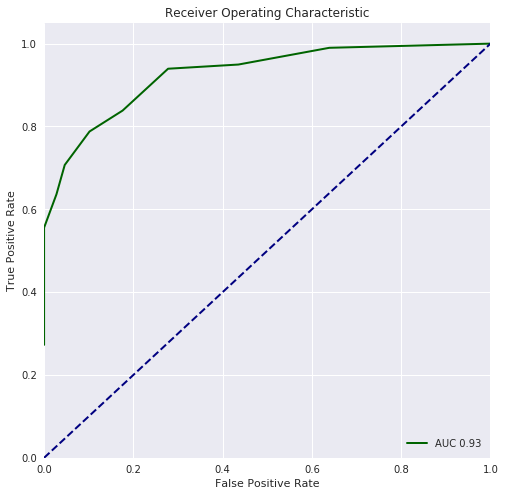

In [40]:
# roc
query = """
    DROP TABLE IF EXISTS public.model_test_scored_xg_roc;
    SELECT madlib.binary_classifier( 
        'public.model_test_scored_xg'
       ,'public.model_test_scored_xg_roc'
       ,'class_label_predicted'
       ,'approval'
    );
"""
cur.execute(query)

query = """
    SELECT threshold
          ,fpr
          ,tpr
    FROM public.model_test_scored_roc
    ORDER BY 1
"""
df = query_gpdb(query)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<a id="xg_confusion_matrix"></a>
#### Confusion Matrix

In [41]:
# confusion matrix (inclusive)
cutoff = 0.5

query = """
        SELECT approval AS obs
              ,CASE WHEN class_label_predicted >= {} THEN 1 ELSE 0 END AS pred
              ,count(*) AS num
        FROM public.model_test_scored_xg
        GROUP BY 1,2
        ORDER BY 1,2
    """.format(cutoff)

query_gpdb(query)

,obs,pred,num
0,0,0,99
1,0,1,9
2,1,0,13
3,1,1,86


----
## Model Scoring

<a id="model_scoring_Example"></a>
#### Model Scoring Example

In [36]:
query = """
    DROP TABLE IF EXISTS public.credit_application_summary;
    SELECT madlib.summary('public.credit_application_data','public.credit_application_summary');
    SELECT * FROM public.credit_application_summary;
"""
data_summary = query_gpdb(query)

featureNames = ['a2', 'a3', 'a8', 'a11', 'a14', 'a15', 'a1_a', 'a4_l', 'a4_u', 'a5_g', 'a5_gg', 'a6_aa', 'a6_c', 'a6_cc', 'a6_d', 'a6_e', 'a6_ff', 'a6_i', 'a6_j', 'a6_k', 'a6_m', 'a6_q', 'a6_r', 'a6_w', 'a7_bb', 'a7_dd', 'a7_ff', 'a7_h', 'a7_j', 'a7_n', 'a7_o', 'a7_v', 'a9_true', 'a10_true', 'a12_true', 'a13_g', 'a13_p']
    

def add_continuous_slider(n, default):
    tstr = "target_column == '{}'".format(n)
    minValue = math.floor(data_summary.query(tstr)['min'])
    minValueOrZero = min(0,float(minValue))
    maxValue = math.ceil(data_summary.query(tstr)['max'])
    return widgets.FloatSlider(
        value=default,
        min=minValueOrZero,
        max=maxValue,
        step=0.1,
        description="",
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )

def add_drop_down(n, default):
    
    query = """
        SELECT {} AS col
        FROM public.credit_application_data
        GROUP BY 1
        ORDER BY 1
    """.format(n)
    values = query_gpdb(query)['col']

    return widgets.Dropdown(
        options=values,
        value=default,
        description='',
        disabled=False,
    )

def add_widgets():
    
    message = "### Loan Application \n ------"
    printmd(message)
    
    myWidgets = []

    myWidgets.append({'a1':add_drop_down('a1','a')})
    myWidgets.append({'a2':add_continuous_slider('a2',35.43)})
    myWidgets.append({'a3':add_continuous_slider('a3',12.0)})
    myWidgets.append({'a4':add_drop_down('a4','u')})
    myWidgets.append({'a5':add_drop_down('a5','g')})
    myWidgets.append({'a6':add_drop_down('a6','q')})
    myWidgets.append({'a7':add_drop_down('a7','h')})
    myWidgets.append({'a8':add_continuous_slider('a8',14.0)})
    myWidgets.append({'a9':add_drop_down('a9',True)})
    myWidgets.append({'a10':add_drop_down('a10',True)})
    myWidgets.append({'a11':add_continuous_slider('a11',8.0)})
    myWidgets.append({'a12':add_drop_down('a12',False)})
    myWidgets.append({'a13':add_drop_down('a13','g')})
    myWidgets.append({'a14':add_continuous_slider('a14',0.0)})
    myWidgets.append({'a15':add_continuous_slider('a15',6590.0)})
    
    for widget in myWidgets:
        n = widget.keys()[0]
        printmd("**{}:**".format(n))
        ipd.display(widget[n])

    message = "------"
    printmd(message)
    
    return myWidgets

    
def create_model_input(myWidgets):

    checks = {}
    conts = []
    f = []
    
    for i in range(0,len(featureNames)):
        f.append(0.0)
    
    for feature in featureNames:
        if "_" in feature:
            key = feature[0:feature.find("_")]
            val = feature[feature.find("_")+1:len(feature)]
            if key in checks:
                checks[key].append(val)
            else:
                checks[key] = [val]
        else:
            conts.append(feature)
            
    for widget in myWidgets:
        n = widget.keys()[0]
        val = widget[n].value

        # lower case boolean strings
        if isinstance(val,np.bool_):
            val = str(val).lower()

        if n in checks:
            checkFlag = False
            for c in checks[n]:
                if c == val:
                    checkFlag = True
                    pos = featureNames.index("{}_{}".format(n,val))
                    f[pos] = 1.0   
                    
            # make all associated values 0
            if checkFlag == False:
                for feature in featureNames:
                    if "_" in feature and feature[0:feature.find("_")+1] == n:
                        pos = featureNames.index(feature)
                        f[pos] = 0.0   
        elif n in conts:
            pos = featureNames.index(n)
            f[pos] = val

    return f
        
def rf_score(modelInputs):
    
    ddlString = "_id integer"
    for f in featureNames:
        ddlString = ddlString + ",{} float".format(f)

    query = """
        DROP TABLE IF EXISTS public.prod_example_data, public.prod_example_score;
        CREATE TABLE public.prod_example_data ({});
        INSERT INTO public.prod_example_data VALUES ({});
        DROP TABLE IF EXISTS public.model_test_scored_tmp;
        SELECT madlib.forest_predict('public.rf_model_output',
                                     'public.prod_example_data',
                                     'public.prod_example_score',
                                     'prob');
        SELECT * FROM public.prod_example_score;
    """.format(ddlString, ",".join(str(x) for x in modelInputs))

    score = float(query_gpdb(query)['estimated_prob_1'])
    
    message = "High"
    if score <= 0.33:
        message = "Low"
    elif score <= 0.66:
        message = "Average"
    
    return (score, message)
    
def on_appbutton_click(b):
    
    ipd.clear_output()
    
    message = "### Loan Approval Results \n------\n"
    printmd(message)
    
    modelInput = create_model_input(myWidgets)
    
    s, m = rf_score(modelInput)
    
    message = "**Approval Score:** {}".format(s)
    printmd(message)
    
    message = "*Your chances of being approved are '{}'*".format(m)
    printmd(message)
    
    cleanModelInputs = ""
    for i in range(0,len(featureNames)):
        cleanModelInputs = cleanModelInputs + "{} = {}\n\n".format(featureNames[i],modelInput[i])

    message = "**Model Inputs:** \n\n{}".format(cleanModelInputs)
    printmd(message)
    
    printmd("\n------")
    
myWidgets = add_widgets()
appbutton = widgets.Button(description="Calculate Approval")
ipd.display(appbutton)
appbutton.on_click(on_appbutton_click)


### Loan Approval Results 
------


**Approval Score:** 0.5

*Your chances of being approved are 'Average'*

**Model Inputs:** 

a2 = 35.43

a3 = 12.0

a8 = 14.0

a11 = 8.0

a14 = 1183.0

a15 = 53881.2

a1_a = 1.0

a4_l = 0.0

a4_u = 1.0

a5_g = 1.0

a5_gg = 0.0

a6_aa = 0.0

a6_c = 0.0

a6_cc = 0.0

a6_d = 0.0

a6_e = 0.0

a6_ff = 0.0

a6_i = 0.0

a6_j = 0.0

a6_k = 0.0

a6_m = 0.0

a6_q = 1.0

a6_r = 0.0

a6_w = 0.0

a7_bb = 0.0

a7_dd = 0.0

a7_ff = 0.0

a7_h = 1.0

a7_j = 0.0

a7_n = 0.0

a7_o = 0.0

a7_v = 0.0

a9_true = 1.0

a10_true = 1.0

a12_true = 0.0

a13_g = 1.0

a13_p = 0.0




------